## Spam Email Classifier with KNN using TF-IDF scores

1.   Assignment must be implemented in Python 3 only.
2.   You are allowed to use libraries for data preprocessing (numpy, pandas, nltk etc) and for evaluation metrics, data visualization (matplotlib etc.).
3.   You will be evaluated not just on the overall performance of the model and also on the experimentation with hyper parameters, data prepossessing techniques etc.
4.   The report file must be a well documented jupyter notebook, explaining the experiments you have performed, evaluation metrics and corresponding code. The code must run and be able to reproduce the accuracies, figures/graphs etc.
5.   For all the questions, you must create a train-validation data split and test the hyperparameter tuning on the validation set. Your jupyter notebook must reflect the same.
6.   Strict plagiarism checking will be done. An F will be awarded for plagiarism.

**Task: Given an email, classify it as spam or ham**

Given input text file ("emails.txt") containing 5572 email messages, with each row having its corresponding label (spam/ham) attached to it.

This task also requires basic pre-processing of text (like removing stopwords, stemming/lemmatizing, replacing email_address with 'email-tag', etc..).

You are required to find the tf-idf scores for the given data and use them to perform KNN using Cosine Similarity.

### Import necessary libraries

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from scipy.spatial.distance import hamming
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import math

In [109]:
#Downloading the nltk libraries
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/soumodiptab/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/soumodiptab/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/soumodiptab/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Load Dataset

In [110]:
"""from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/smai/
"""
data=pd.read_csv('emails.txt',sep='\t',header=None)
data.columns=['type','text']
data

,type,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


### Preprocess data:
1. Removing Punctuation
2. Tokenizing
3. Converting to lower case
4. Removing stop words
5. Lemmatizing the tokens

In [111]:
# punctuations
punctuations=string.punctuation
# stopwords
stop_words=stopwords.words('english')
def remove_punctuations(text):
  for c in punctuations:
    text=text.replace(c," ")
  return text
wn = WordNetLemmatizer()
#removing stopwords
data['text'] = data['text'].apply(remove_punctuations)
#tokenizing the text
data['text'] = data['text'].apply(word_tokenize)
#removing the 
data['text'] = data['text'].apply(lambda x: ([word.lower() for word in x if word.lower() not in stop_words]))
#Lemmatizing
data['text'] = data['text'].apply(lambda x: [wn.lemmatize(word) for word in x])

In [112]:
data.sample(10)

,type,text
4268,ham,"[sorry, im, stil, fucked, last, nite, went, to..."
710,spam,"[4mths, half, price, orange, line, rental, lat..."
4184,ham,"[sorry, call, later, meeting]"
2162,ham,"[replying, boye, changed, phone, number]"
4152,ham,"[ü, comin, fetch, u, oredi]"
2257,ham,"[checked, heading, drop, stuff]"
779,ham,"[happy, new, year, dear, brother, really, miss..."
1078,ham,"[yep, pretty, sculpture]"
217,ham,"[tired, slept, well, past, night]"
3169,ham,"[ugh, hopefully, asus, ppl, dont, randomly, re..."


In [113]:
#removing lines with empty text
data=data[data['text'].map(lambda d: len(d)) > 0]
data.sample(10)

,type,text
2415,ham,[fps]
2739,ham,"[sent, price, mean, lt, gt, g]"
1821,ham,"[probably, tomorrow, even, later, tonight, som..."
4974,ham,"[oops, shower, u, called, hey, parking, garage..."
1863,ham,"[last, thing, ever, wanted, hurt, think, would..."
3988,spam,"[ringtone, club, gr8, new, polys, direct, mobi..."
890,ham,"[wife, knew, time, murder, exactly]"
3533,ham,"[actually, mobile, full, msg, work, online, ne..."
3220,ham,"[baby, promise, treat, well, bet, take, good, ..."
3957,ham,"[haha, dont, angry, take, practice, real, thing]"


#### Splitting Cleaned Data into test and train:

In [114]:
text_train, text_test,labels_train, labels_test = train_test_split(data['text'],data['type'] ,test_size=0.20, random_state=42)
labels_train=np.array(labels_train)
labels_test=np.array(labels_test)
text_train=np.array(text_train)
text_test=np.array(text_test)

##### Functions to calculate TF-IDF

In [115]:
def term_freq(sentence, word):
    N = len(sentence)
    freq = len([x for x in sentence if x==word])
    return freq/float(N)

def inverse_doc_freq(word,doc_word_count,total_sentences):
    doc_freq = doc_word_count[word] + 1
    return math.log10(total_sentences/float(doc_freq))

def tf_idf(sentence,doc_word_count,index_unique_words,unique_words,total_sentences):
    tf_idf_vector = np.zeros((len(unique_words),))
    for word in set(sentence):
      tf = term_freq(sentence,word)
      idf = inverse_doc_freq(word,doc_word_count,total_sentences)
      value = tf*idf
      tf_idf_vector[index_unique_words[word]] = value
    return tf_idf_vector
test_data=[]

In [116]:
def build_unique_words(data_frame_col):
  unique_words=set()
  for text in data_frame_col:
    unique_words=unique_words.union(set(text))
  return unique_words
def build_doc_freq(data_frame_col,unique_words):
  doc_word_count=dict.fromkeys(unique_words, 0)
  for text in data_frame_col:
    for word in unique_words:
      if word in text:
        doc_word_count[word]+=1
  return doc_word_count
def calc_tf_idf(data_frame_col):
  total_sentences=len(data_frame_col)
  unique_words=build_unique_words(data_frame_col)
  #for calculation of document freq:
  doc_word_count=build_doc_freq(data_frame_col,unique_words)
  print(doc_word_count)
  index_unique_words={}
  index=0
  for word in unique_words:
    index_unique_words[word]=index
    index+=1
  vectors=[]
  for sentence in data_frame_col:
    tf_idf_vector = tf_idf(sentence,doc_word_count,index_unique_words
                             ,unique_words,total_sentences)
    vectors.append(tf_idf_vector)
  return vectors,index_unique_words,doc_word_count,total_sentences
#labels=np.array(data['type'])
#vectors=calc_tf_idf(data['text'])
#test_data=data['text'].sample(10)
#vectors,index_dict=calc_tf_idf(test_data)
#test_data

##### Calculating the TF-IDF Vector for the Train Data

In [117]:
vectors_train,index_unique_words,doc_word_count,total_sentences=calc_tf_idf(text_train)

{'anderson': 1, 'revision': 1, 'freek': 1, 'sens': 1, 'harder': 1, 'auntie': 1, 'properly': 2, 'wed': 5, 'tron': 1, 'untamed': 2, 'stuck': 3, 'argentina': 1, 'lord': 1, 'sam': 4, '69200': 1, 'chillin': 3, 'asa': 1, 'fondly': 1, 'hanumanji': 1, 'dunno': 24, '5wb': 4, 'street': 9, 'honestly': 1, 'glorious': 1, 'necesity': 1, 'walk': 14, 'wnt': 3, 'siva': 1, 'abt': 19, 'user': 7, 'addie': 2, 'onum': 1, 'lip': 3, 'probs': 1, 'pair': 1, 'onluy': 1, 'sim': 7, 'subscribed': 2, 'vry': 4, 'tallent': 1, 'mg': 1, 'revealing': 1, 'soup': 3, 'nange': 1, 'sake': 2, 'cribbs': 1, 'interviw': 1, 'goigng': 1, 'mum': 19, 'zero': 1, '08719180219': 1, 'poured': 1, 'waliking': 1, 'sometme': 1, '121': 2, 'soladha': 1, 'scenery': 1, 'mob': 17, 'lightly': 1, 'sitter': 1, 'stay': 19, 'abuser': 1, 'nobbing': 1, 'saw': 17, 'sup': 6, 'box1146': 1, '2': 335, '8007': 10, '83355': 4, 'knock': 1, 'del': 9, 'available': 13, 'sale': 7, 'pthis': 1, 'life': 54, 'divert': 1, '09095350301': 1, 'aptitude': 1, '3650': 2, 'mee

##### Calculating TF-IDF for Test data using Train Vector size

In [118]:
#testing data
def testing_tf_idf(data,index_unique_words,doc_word_count,total_sentences):
  vectors=[]
  i=0
  for sentence in data:
    unique_words=index_unique_words.keys()
    vector=np.zeros((len(unique_words),))
    for word in set(sentence):
      if word not in unique_words:
        continue
      tf = term_freq(sentence,word)
      idf = inverse_doc_freq(word,doc_word_count,total_sentences+1)
      value = tf*idf
      vector[index_unique_words[word]] = value
    vectors.append(vector)
    i+=1
  return vectors
vectors_test=testing_tf_idf(text_test,index_unique_words,doc_word_count,total_sentences)

In [119]:
#labels_train, labels_test, vectors_train, vectors_test = train_test_split(labels, vectors, test_size=0.05, random_state=42)
print(len(index_unique_words))

7280


In [120]:
print(len(labels_test))
print(len(labels_train))
print(len(vectors_test))
print(len(vectors_train))

1113
4452
1113
4452


### Train your KNN model (reuse previously iplemented model built from scratch) and test on your data

***1. Experiment with different distance measures [Euclidean distance, Manhattan distance, Hamming Distance] and compare with the Cosine Similarity distance results.***

In [121]:
#Calculating cosine similarity
def cosine_distance(vector_a,vector_b):
  dot_product=np.dot(vector_a, vector_b)
  mag_a=math.sqrt(np.dot(vector_a, vector_a.T))
  mag_b=math.sqrt(np.dot(vector_b,vector_b.T))
  val=0
  if mag_a != 0 and mag_b != 0:
    val=dot_product/float(mag_a*mag_b)
  return (1.0-(val))
def euclidean_distance(vector_a,vector_b):
  return np.linalg.norm(vector_a - vector_b)
def manhattan_distance(a, b):
    return np.abs(a - b).sum()
def hamming_distance(vector_a,vector_b):
  return hamming(vector_a,vector_b)*len(vector_a)
def calc_distance(vector_a,vector_b,metric):
  if metric == "euclidean":
    return euclidean_distance(vector_a,vector_b)
  elif metric == "manhattan":
    return manhattan_distance(vector_a,vector_b)
  elif metric == "hamming":
    return hamming_distance(vector_a,vector_b)
  else:
    return cosine_distance(vector_a,vector_b)

Assigns class based on majority

In [122]:
def get_class(selected_values):
    s,h = 0,0
    for value in selected_values:
        if value == "spam":
            s += 1
        else:
            h += 1
    if s > h:
        return "spam"
    else:
        return "ham"

* f1_score calculates the f1 score
* score_display prints confusionmatrix,precision,recall,f1_score

In [123]:
def score_display(y_true,y_pred,labels):
    print('Confusion matrix: ')
    print(confusion_matrix(y_true, y_pred,labels=labels))
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred,labels=labels).ravel()
    precision=tp/(tp+fp)
    print('Precision: ',end='')
    print(precision,end='')
    recall=tp/(tp+fn)
    print('\tRecall: ',end='')
    print(recall,end='')
    f1_score=2*(precision*recall)/(precision+recall)
    print('\tF1 Score: ',end='')
    print(f1_score,end='')
    print('\tAccuracy: ',end='')
    print(accuracy_score(y_true,y_pred))
def f1_score(y_true,y_pred,labels):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred,labels=labels).ravel()
    precision=tp/(tp+fp)
    recall=tp/(tp+fn)
    f1_score=2*(precision*recall)/(precision+recall)
    return f1_score

Implementation of K-NN

In [124]:

def k_nearest_neighbours(k,train_data,train_labels,test_data,metric="cosine"):
  test_labels=[]
  for i in range(len(test_data)):
    k_labels=[]
    distances=[]
    for j in range(len(train_data)):
      distance=calc_distance(test_data[i],train_data[j],metric)
      distances.append((distance,train_labels[j]))
    top_k_labels=[]
    distances.sort()
    for j  in distances[:k]:
      top_k_labels.append(j[1])
    test_labels.append(get_class(top_k_labels))
  test_labels=np.array(test_labels)
  return test_labels
#testing_labels=k_nearest_neighbours(5,vectors_train,labels_train,vectors_test)
#f1_score(labels_test,testing_labels,['ham','spam'])

KNN for list of k values

In [125]:
#using an array of k-values
def k_nearest_neighbours_batch(k_values,train_data,train_labels,test_data,true_label,metric="cosine",display=False):
    xtrue_label=np.array(true_label)
    all_distances=[]
    for i in range(len(test_data)):
        distances=[]
        for j in range(len(train_data)):
            distance=calc_distance(test_data[i],train_data[j],metric)
            distances.append((distance,train_labels[j]))
        distances.sort()
        all_distances.append(distances)
    f1_scores=[]
    for k in k_values:
        test_labels=[]
        for i in range(len(test_data)):
            top_k_labels=[]
            for pair  in all_distances[i][:k]:
                top_k_labels.append(pair[1])
            test_labels.append(get_class(top_k_labels))
        test_labels=np.array(test_labels)
        score=f1_score(xtrue_label,test_labels,['ham','spam'])
        if display:
            print(f"k = {k}")
            score_display(xtrue_label,test_labels,['ham','spam'])
        f1_scores.append(score)
    return f1_scores

In [126]:
cosine_labels=k_nearest_neighbours(5,vectors_train,labels_train,vectors_test)
score_display(labels_test,cosine_labels,['ham','spam'])

Confusion matrix: 
[[949   2]
 [ 42 120]]
Precision: 0.9836065573770492	Recall: 0.7407407407407407	F1 Score: 0.8450704225352113	Accuracy: 0.9604672057502246


In [127]:
euclidean_labels=k_nearest_neighbours(5,vectors_train,labels_train,vectors_test)
score_display(labels_test,euclidean_labels,['ham','spam'])

Confusion matrix: 
[[949   2]
 [ 42 120]]
Precision: 0.9836065573770492	Recall: 0.7407407407407407	F1 Score: 0.8450704225352113	Accuracy: 0.9604672057502246


In [128]:
manhattan_labels=k_nearest_neighbours(5,vectors_train,labels_train,vectors_test)
score_display(labels_test,manhattan_labels,['ham','spam'])

Confusion matrix: 
[[949   2]
 [ 42 120]]
Precision: 0.9836065573770492	Recall: 0.7407407407407407	F1 Score: 0.8450704225352113	Accuracy: 0.9604672057502246


In [129]:
k_values=[1,3,5,7,11,17,23,28]

***2. Explain which distance measure works best and why? Explore the distance measures and weigh their pro and cons in different application settings.***

According to our experiment

***3. For evaluating model, show confusion matrix, accuracy, recall, precision and F1-score. Answer why accuracy alone is not sufficient to evaluate the model. Why we need precision/recall/f1-score. ?***

Cosine Metric

In [130]:
k_nearest_neighbours_batch(k_values,vectors_train,labels_train,vectors_test,labels_test,metric="cosine",display=True)

k = 1
Confusion matrix: 
[[948   3]
 [ 17 145]]
Precision: 0.9797297297297297	Recall: 0.8950617283950617	F1 Score: 0.9354838709677419	Accuracy: 0.9820305480682839
k = 3
Confusion matrix: 
[[949   2]
 [ 33 129]]
Precision: 0.9847328244274809	Recall: 0.7962962962962963	F1 Score: 0.8805460750853241	Accuracy: 0.9685534591194969
k = 5
Confusion matrix: 
[[949   2]
 [ 42 120]]
Precision: 0.9836065573770492	Recall: 0.7407407407407407	F1 Score: 0.8450704225352113	Accuracy: 0.9604672057502246
k = 7
Confusion matrix: 
[[948   3]
 [ 41 121]]
Precision: 0.9758064516129032	Recall: 0.7469135802469136	F1 Score: 0.8461538461538461	Accuracy: 0.9604672057502246
k = 11
Confusion matrix: 
[[949   2]
 [ 44 118]]
Precision: 0.9833333333333333	Recall: 0.7283950617283951	F1 Score: 0.8368794326241135	Accuracy: 0.958670260557053
k = 17
Confusion matrix: 
[[948   3]
 [ 44 118]]
Precision: 0.9752066115702479	Recall: 0.7283950617283951	F1 Score: 0.8339222614840989	Accuracy: 0.9577717879604672
k = 23
Confusion matr

[0.9354838709677419,
 0.8805460750853241,
 0.8450704225352113,
 0.8461538461538461,
 0.8368794326241135,
 0.8339222614840989,
 0.8102189781021897,
 0.7790262172284643]

Euclidean Metric

In [131]:
k_nearest_neighbours_batch(k_values,vectors_train,labels_train,vectors_test,labels_test,metric="euclidean",display=True)

k = 1
Confusion matrix: 
[[933  18]
 [ 36 126]]
Precision: 0.875	Recall: 0.7777777777777778	F1 Score: 0.823529411764706	Accuracy: 0.9514824797843666
k = 3
Confusion matrix: 
[[938  13]
 [ 67  95]]
Precision: 0.8796296296296297	Recall: 0.5864197530864198	F1 Score: 0.7037037037037037	Accuracy: 0.9281221922731356
k = 5
Confusion matrix: 
[[940  11]
 [ 75  87]]
Precision: 0.8877551020408163	Recall: 0.5370370370370371	F1 Score: 0.6692307692307694	Accuracy: 0.9227313566936208
k = 7
Confusion matrix: 
[[943   8]
 [ 86  76]]
Precision: 0.9047619047619048	Recall: 0.4691358024691358	F1 Score: 0.6178861788617886	Accuracy: 0.9155435759209344
k = 11
Confusion matrix: 
[[943   8]
 [ 97  65]]
Precision: 0.8904109589041096	Recall: 0.4012345679012346	F1 Score: 0.5531914893617021	Accuracy: 0.9056603773584906
k = 17
Confusion matrix: 
[[944   7]
 [111  51]]
Precision: 0.8793103448275862	Recall: 0.3148148148148148	F1 Score: 0.4636363636363637	Accuracy: 0.8939802336028752
k = 23
Confusion matrix: 
[[946   

[0.823529411764706,
 0.7037037037037037,
 0.6692307692307694,
 0.6178861788617886,
 0.5531914893617021,
 0.4636363636363637,
 0.37073170731707317,
 0.25]

Manhattan Metric

In [132]:
k_nearest_neighbours_batch(k_values,vectors_train,labels_train,vectors_test,labels_test,metric="euclidean",display=True)

k = 1
Confusion matrix: 
[[933  18]
 [ 36 126]]
Precision: 0.875	Recall: 0.7777777777777778	F1 Score: 0.823529411764706	Accuracy: 0.9514824797843666
k = 3
Confusion matrix: 
[[938  13]
 [ 67  95]]
Precision: 0.8796296296296297	Recall: 0.5864197530864198	F1 Score: 0.7037037037037037	Accuracy: 0.9281221922731356
k = 5
Confusion matrix: 
[[940  11]
 [ 75  87]]
Precision: 0.8877551020408163	Recall: 0.5370370370370371	F1 Score: 0.6692307692307694	Accuracy: 0.9227313566936208
k = 7
Confusion matrix: 
[[943   8]
 [ 86  76]]
Precision: 0.9047619047619048	Recall: 0.4691358024691358	F1 Score: 0.6178861788617886	Accuracy: 0.9155435759209344
k = 11
Confusion matrix: 
[[943   8]
 [ 97  65]]
Precision: 0.8904109589041096	Recall: 0.4012345679012346	F1 Score: 0.5531914893617021	Accuracy: 0.9056603773584906
k = 17
Confusion matrix: 
[[944   7]
 [111  51]]
Precision: 0.8793103448275862	Recall: 0.3148148148148148	F1 Score: 0.4636363636363637	Accuracy: 0.8939802336028752
k = 23
Confusion matrix: 
[[946   

[0.823529411764706,
 0.7037037037037037,
 0.6692307692307694,
 0.6178861788617886,
 0.5531914893617021,
 0.4636363636363637,
 0.37073170731707317,
 0.25]

Hamming Metric

In [ ]:
k_nearest_neighbours_batch(k_values,vectors_train,labels_train,vectors_test,labels_test,metric="hamming",display=True)

**Why accuracy is not sufficient?**


***4. Choose different K values (k=1,3,5,7,11,17,23,28) and experiment. Plot a graph showing F1 - score vs k.***

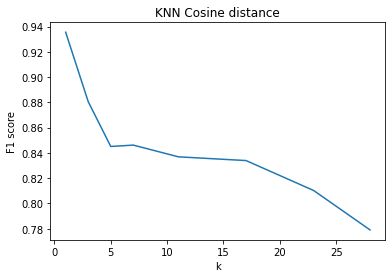

In [133]:
f1_scores_cosine=k_nearest_neighbours_batch(k_values,vectors_train,labels_train,vectors_test,labels_test,metric="cosine")
plt.plot(k_values,f1_scores_cosine)
plt.xlabel("k")
plt.ylabel("F1 score")
plt.title("KNN Cosine distance")
plt.show()

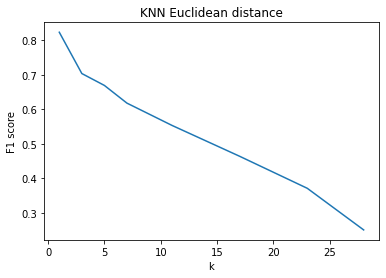

In [134]:
f1_scores_euclidean=k_nearest_neighbours_batch(k_values,vectors_train,labels_train,vectors_test,labels_test,metric="euclidean")
plt.plot(k_values,f1_scores_euclidean)
plt.xlabel("k")
plt.ylabel("F1 score")
plt.title("KNN Euclidean distance")
plt.show()

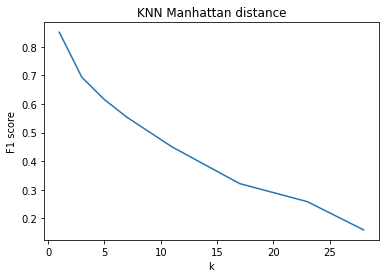

In [135]:
f1_scores_manhattan=k_nearest_neighbours_batch(k_values,vectors_train,labels_train,vectors_test,labels_test,metric="manhattan")
plt.plot(k_values,f1_scores_manhattan)
plt.xlabel("k")
plt.ylabel("F1 score")
plt.title("KNN Manhattan distance")
plt.show()

### Train and test Sklearn's KNN classifier model on your data (use metric which gave best results on your experimentation with built-from-scratch model.)

Using ideal TF-IDF Vectorizer to compare results between own TF-IDF and sklearn's TF-IDF

In [136]:
tfidf = TfidfVectorizer(tokenizer=lambda x:x, stop_words=None, lowercase=False)    
tf_idf_text = tfidf.fit_transform(data['text'])
x_train, x_test, y_train, y_test = train_test_split(tf_idf_text, data['type'], test_size=0.2, random_state=42)

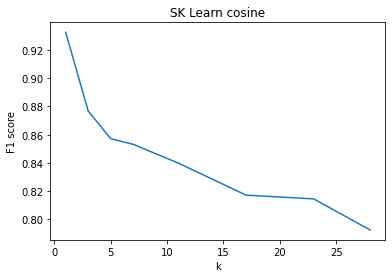

In [137]:
k_values=[1,3,5,7,11,17,23,28]
accuracy_list_pred_sk=[]
predicted_labels_list_sk=[]
for k in k_values:
  neigh = KNeighborsClassifier(n_neighbors=k,metric='cosine')
  neigh.fit(x_train,y_train)
  predicted_labels_sk=neigh.predict(x_test)
  score=f1_score(y_test,predicted_labels_sk,labels=['ham','spam'])
  accuracy_list_pred_sk.append(score)
  predicted_labels_list_sk.append(predicted_labels_sk)
plt.plot(k_values,accuracy_list_pred_sk)
plt.xlabel("k")
plt.ylabel("F1 score")
plt.title("SK Learn cosine")
plt.show()

***Compare both the models result.***

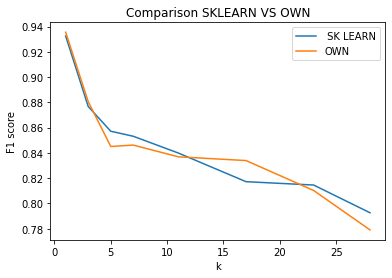

In [141]:
plt.plot(k_values,accuracy_list_pred_sk,label=" SK LEARN")
plt.plot(k_values,f1_scores_cosine,label="OWN")
plt.legend()
plt.xlabel("k")
plt.ylabel("F1 score")
plt.title("Comparison SKLEARN VS OWN")
plt.show()

***What is the time complexity of training using KNN classifier?***

***What is the time complexity while testing? Is KNN a linear classifier or can it learn any boundary?***